# Трансформеры

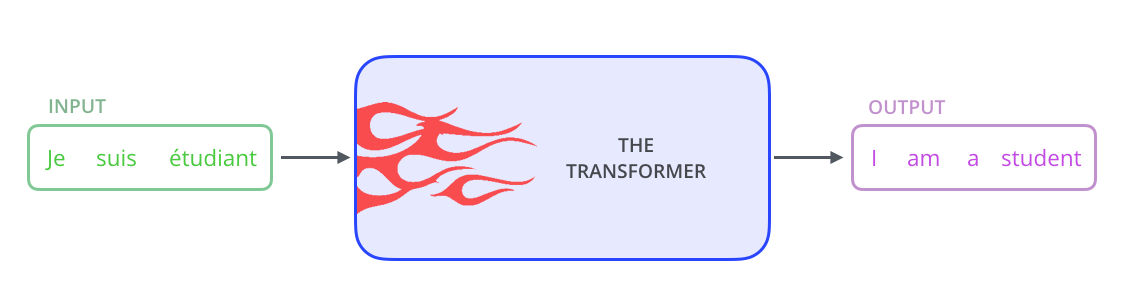

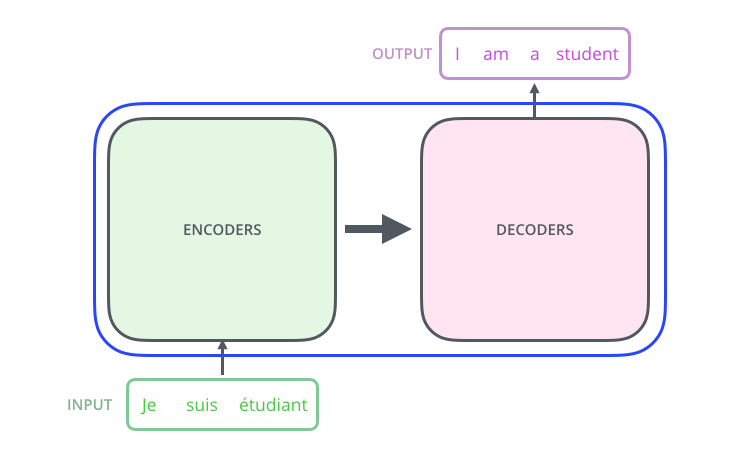

## Как работают трансформеры в NLP

Все энкодеры идентичны по структуре, хотя и имеют разные веса. Каждый можно разделить на два подслоя:

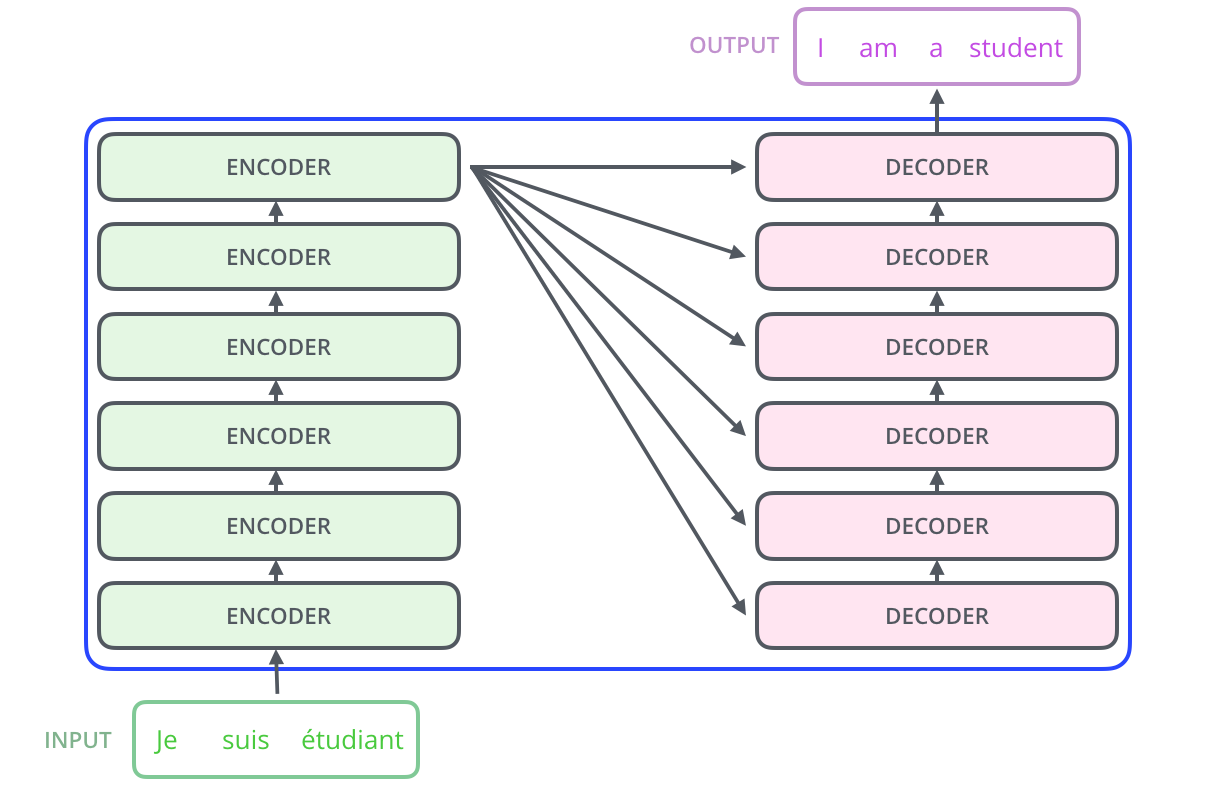

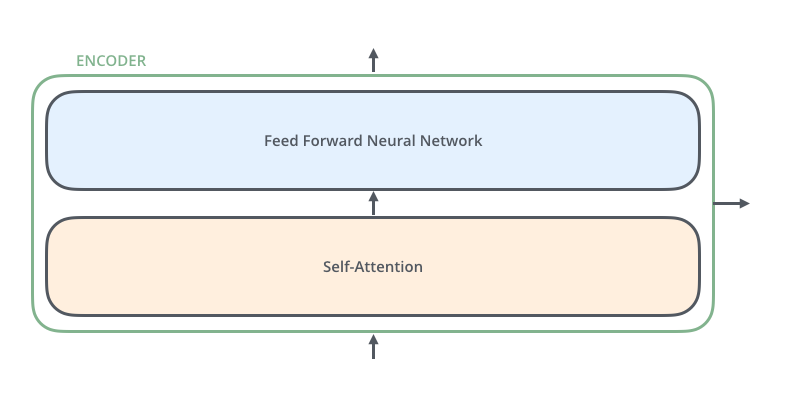

Входная последовательность, поступающая в энкодер, сначала проходит через слой внутреннего внимания (self-attention), помогающий энкодеру посмотреть на другие слова во входящем предложении во время кодирования конкретного слова. Выход слоя внутреннего внимания отправляется в нейронную сеть прямого распространения (feed-forward neural network). Точно такая же сеть независимо применяется для каждого слова в предложении.

Декодер также содержит два этих слоя, но между ними есть слой внимания, который помогает декодеру фокусироваться на релевантных частях входящего предложения.

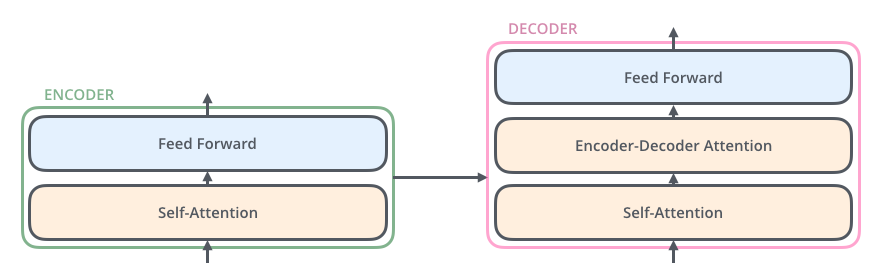

### Под копотом

Сначала каждому токену (слову) назначаем вектор (через токенизитор и ембеддер).

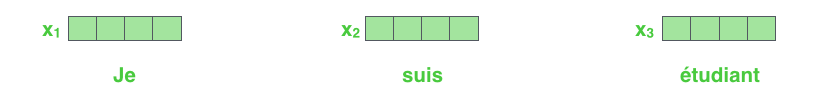

Эмбеддинги применяются только в самом нижнем энкодере. На уровне абстракции, общей для всех энкодеров, происходит следующее: энкодеры получают набор векторов размерностью 512 (для самого нижнего энкодера это будут эмбеддинги слов, для других – выходные вектора нижестоящих энкодеров). Размер этого набора векторов является гиперпараметром, который мы можем устанавливать, и, по сути, равен длине самого длинного предложения в обучающем корпусе. После того как слова входящего предложения преобразовались в эмбеддинги, каждый из них в отдельности проходит через два слоя энкодера.

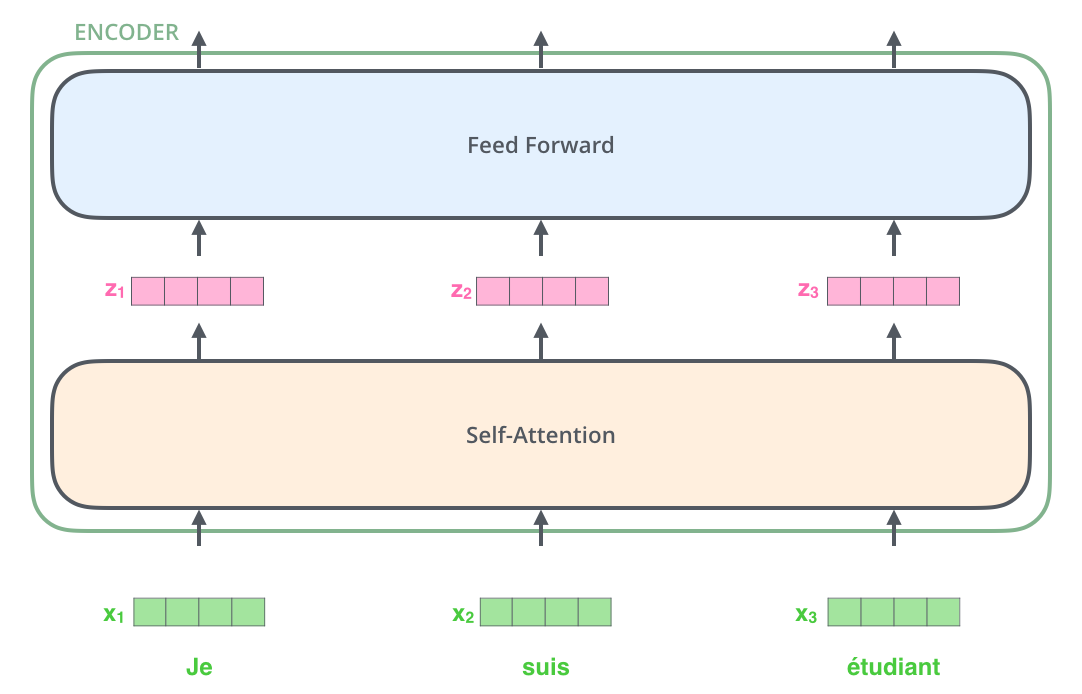

Здесь изображена одна из основных особенностей Трансформера: каждое слово идет по своей собственной траектории в энкодере. И, хотя существуют зависимости между этими траекториями в слое внутреннего внимания, в слое сети прямого распространения таких зависимостей нет, что позволяет различным траекториям выполняться параллельно во время прохождения через этот слой.

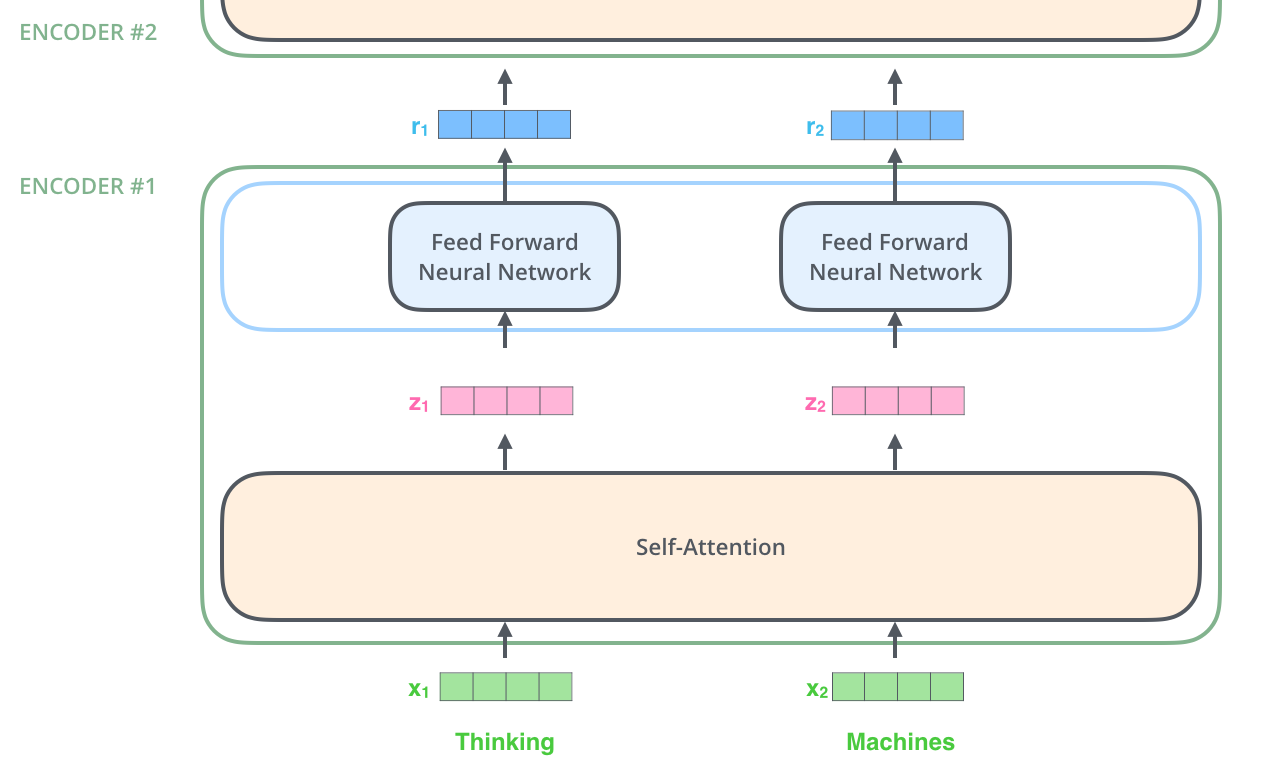

#### Механизм внимания

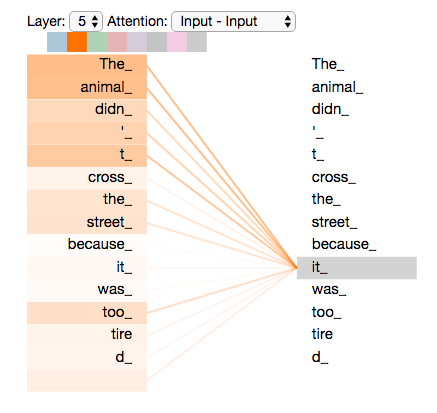

Тут можете потыкать визуализацию: https://colab.research.google.com/github/tensorflow/tensor2tensor/blob/master/tensor2tensor/notebooks/hello_t2t.ipynb

Первый этап в вычислении внутреннего внимания – это создать три вектора из каждого входящего вектора (в нашем случае – эмбеддинга каждого слова): вектор запроса (Query vector), вектор ключа (Key vector) и вектор значения (Value vector). Эти векторы создаются с помощью перемножения эмбеддинга на три матрицы, которые мы обучили во время процесса обучения.

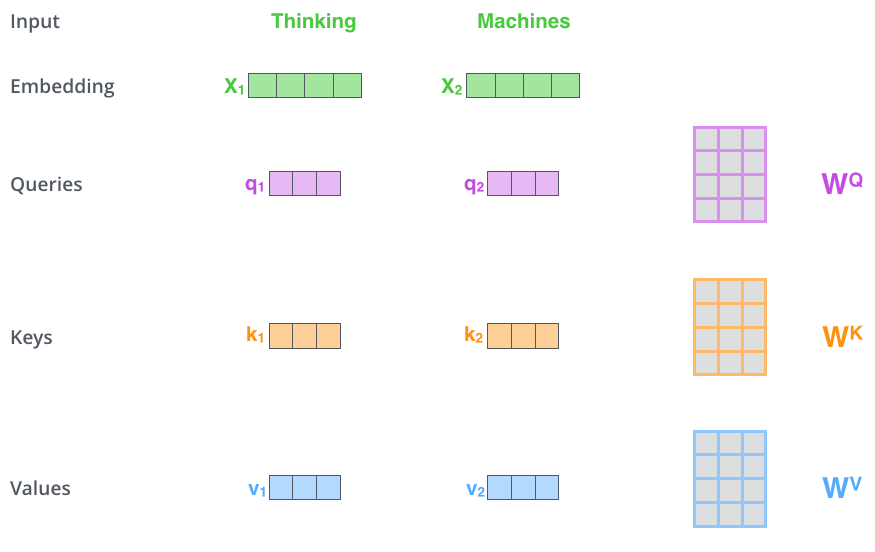

Умножение x1 на матрицу весов WQ производит q1, вектор «запроса», относящийся к этому слову. В итоге мы создаем проекции «запроса», «ключа» и «значения» для каждого слова во входящем предложении.

Второй этап вычисления внутреннего внимания – получение коэффициента (score). Допустим, мы подсчитываем внутреннее внимание для первого слова в нашем примере – «Thinking». Нам нужно оценить каждое слово во входящем предложении по отношению к данному слову. Коэффициент определяет, насколько нужно сфокусироваться на других частях входящего предложения во время кодирования слова в конкретной позиции.

Коэффициент подсчитывается с помощью скалярного произведения вектора запроса и вектора ключа соответствующего слова. Таким образом, если мы вычисляем внутреннее внимание для слова в позиции #1, первый коэффициент будет скалярным произведением q1 и k1, второй — скалярным произведением q1 и k2.

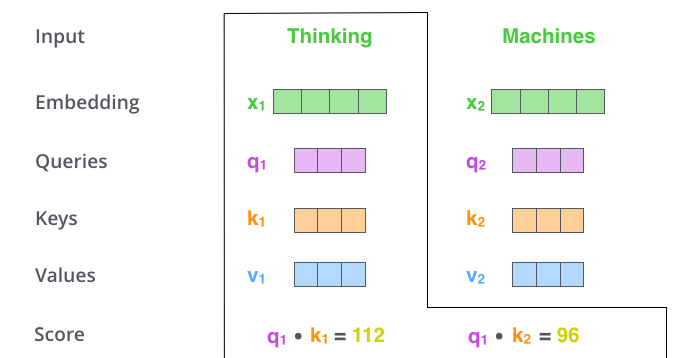

Третий и четвертый этапы – разделить эти коэффициенты на 8 (квадратный корень размерности векторов ключа, используемой в статье – 64; данное значение обеспечивает более стабильные градиенты и используется по умолчанию, но возможны также и другие значения), а затем пропустить результат через функцию софтмакс (softmax). Данная функция нормализует коэффициенты так, чтобы они были положительными и в сумме давали 1.

Полученный софтмакс-коэффициент (softmax score) определяет, в какой мере каждое из слов предложения будет выражено в определенной позиции. Очевидно, что слово в своей позиции получит наибольший софтмакс-коэффициент, но иногда полезно учитывать и другое слово, релевантное к рассматриваемому.

Пятый этап – умножить каждый вектор значения на софтмакс-коэффициент (перед их сложением). Интуиция здесь следующая: нужно держать без изменений значения слов, на которых мы фокусируемся, и отвести на второй план нерелевантные слова (умножив их на небольшие значения, например, 0.001).

Шестой этап – сложить взвешенные векторы значения. Это и будет представлять собой выход слоя внутреннего внимания в данной позиции (для первого слова).

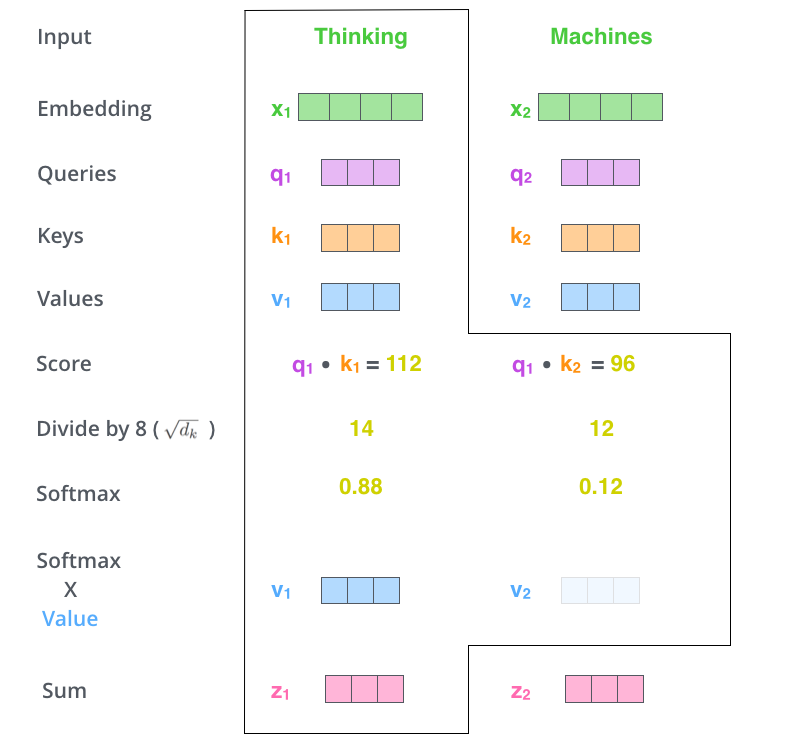

На этом завершается вычисление внутреннего внимания. В результате мы получаем вектор, который можем передавать дальше в нейронную сеть прямого распространения.

По факту все внимание выглядит вот так:

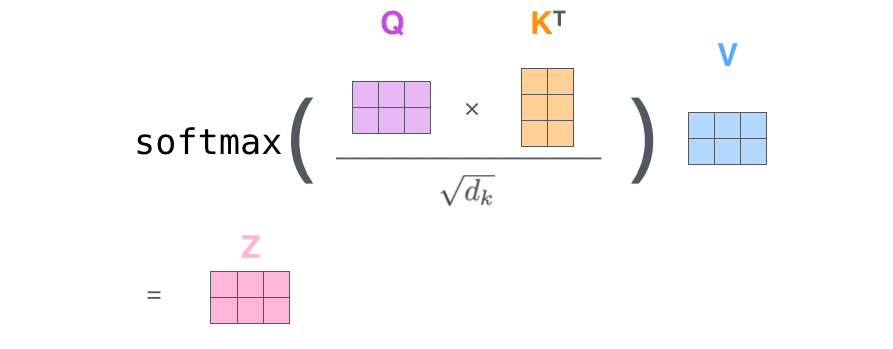

#### Многоголовое внимание

Далее в статье внутреннее внимание совершенствуется с помощью добавления механизма, называющегося множественным вниманием (multi-head attention). Данная техника улучшает производительность слоя внутреннего внимания за счет следующих аспектов:


Повышается способность модели фокусироваться на разных позициях. Да, в примере выше, z1 содержит немного от всех других кодировок, но он не может доминировать над самим словом. В случае с переводом предложения вроде «The animal didn’t cross the street because it was too tired», мы хотим знать, к какому слову относится «it».
Слой внимания снабжается множеством «подпространств представлений» (representation subspaces). Как мы увидим далее, с помощью множественного внимания у нас есть не один, а множество наборов матриц запроса/ключа/значения (Трансформер использует 8 «голов» внимания, так что в итоге у нас получается 8 наборов для каждого энкодера/декодера). Каждый из этих наборов создается случайным образом. Далее после обучения каждый набор используется для отображения входящих эмбеддингов (или векторов с нижестоящих энкодеров/декодеров) в разных подпространствах представлений.

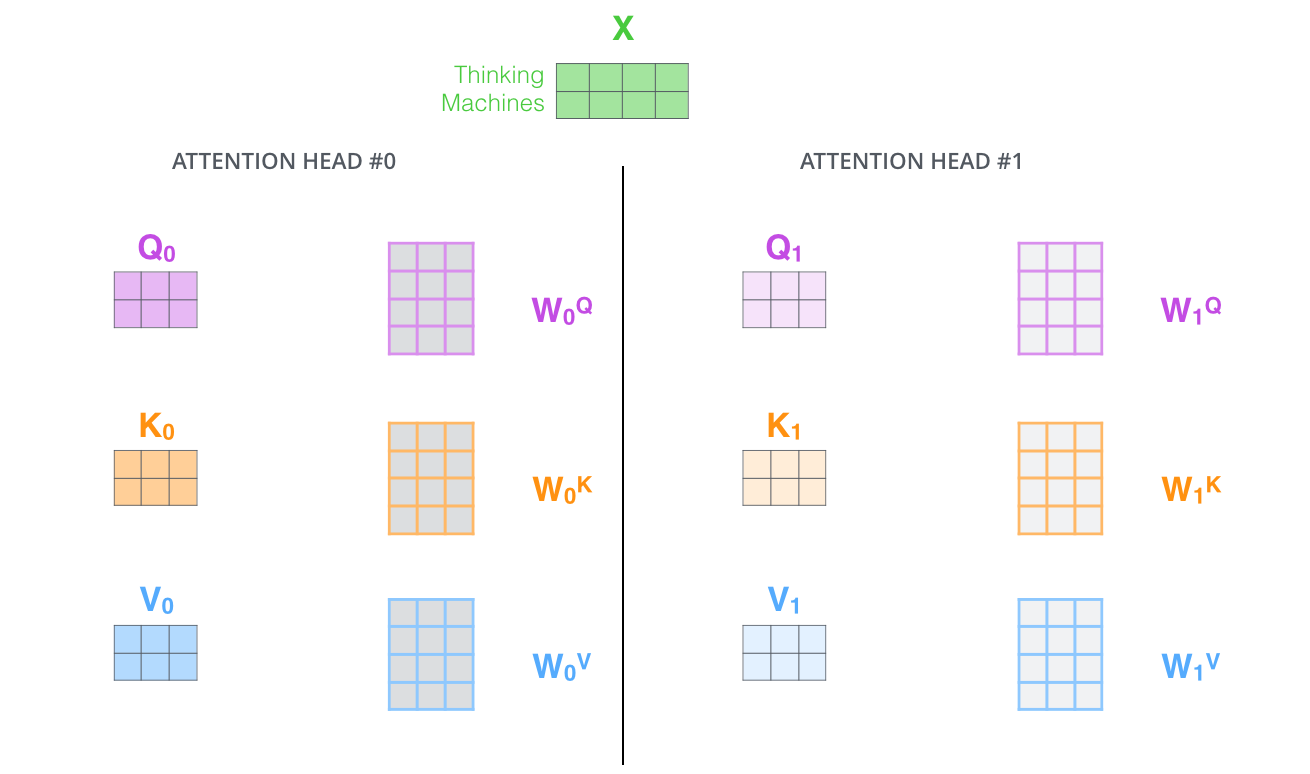

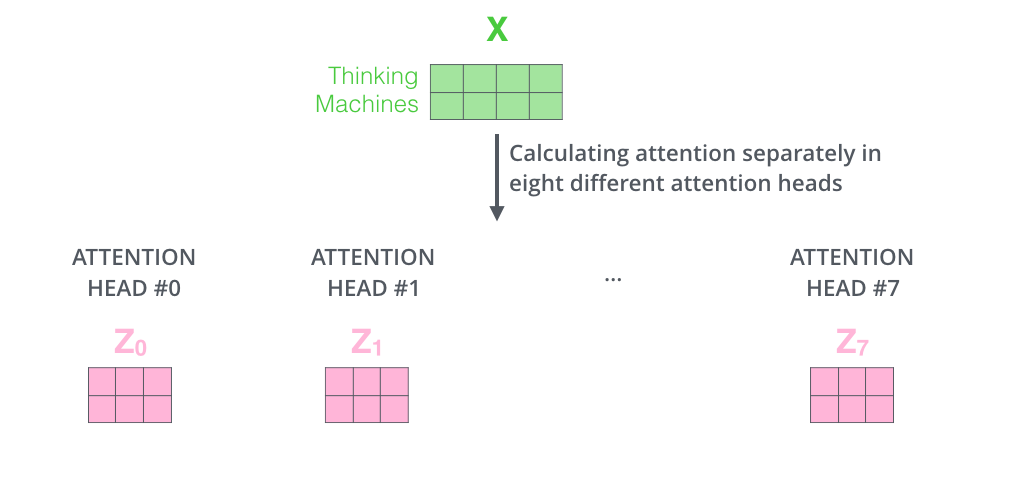

Это бросает нам определенный вызов. Слой сети прямого распространения не ожидает, что к нему поступит 8 матриц – он ждет всего одну (вектор для каждого слова), в которую нам и необходимо сжать полученные Z матрицы.


Как это сделать? Конкатенировать и затем умножить их на дополнительные веса матрицы WO.

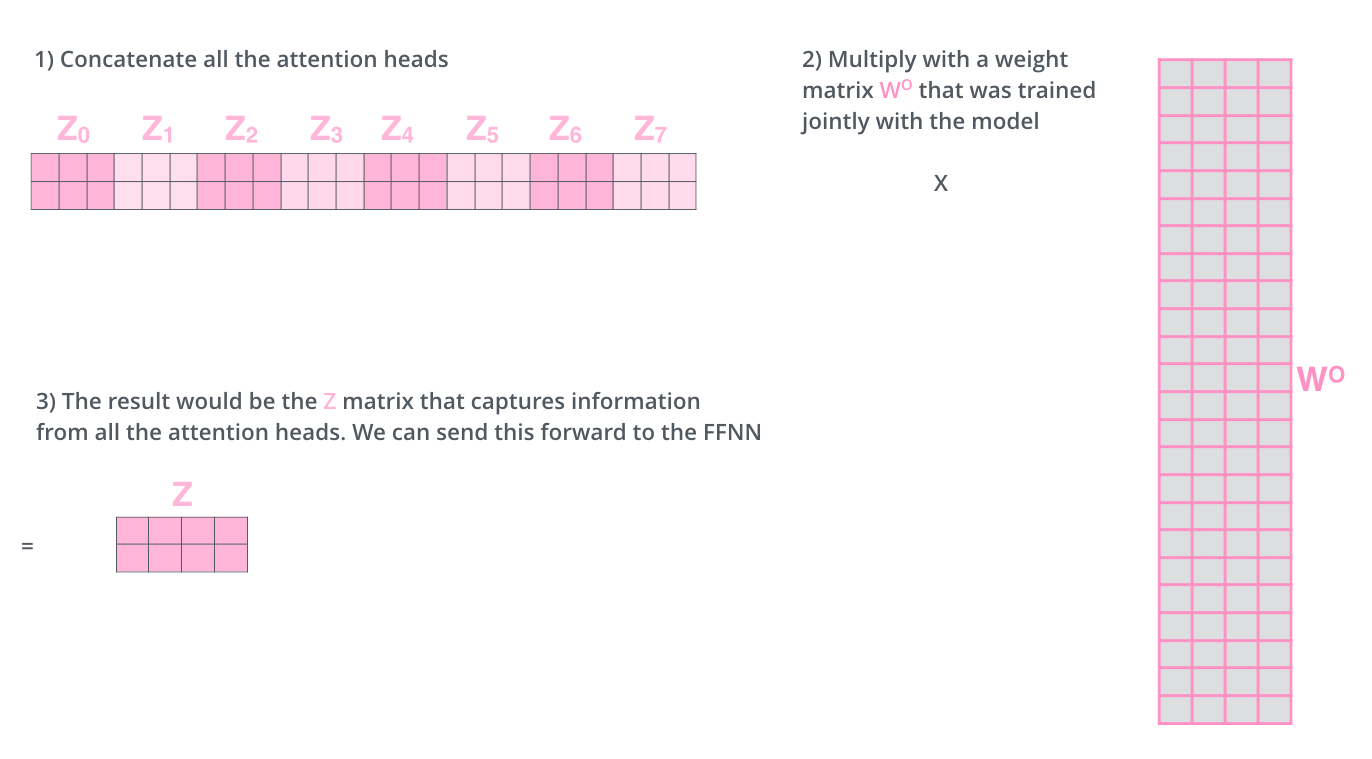

#### Итого

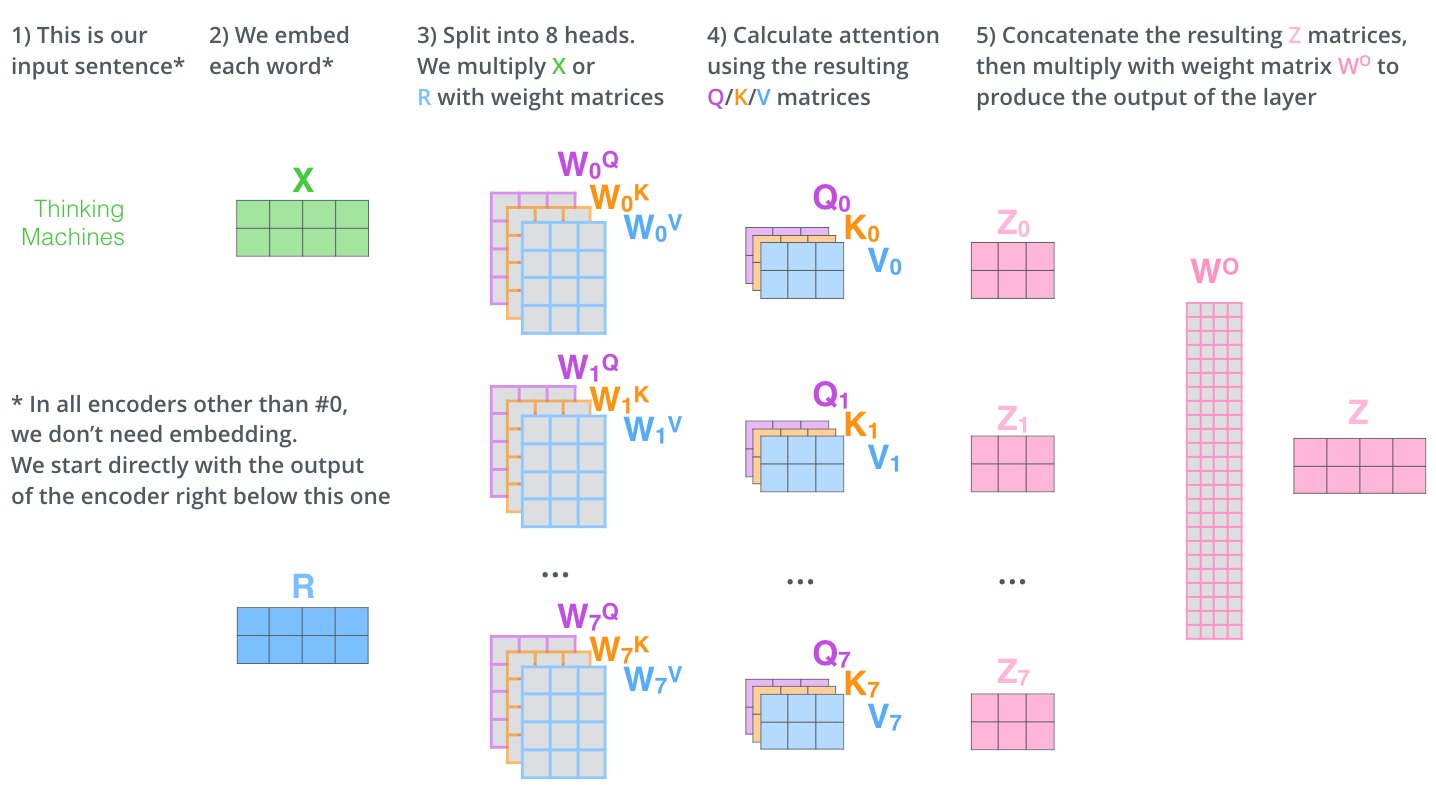

Вот пример с двумя головами

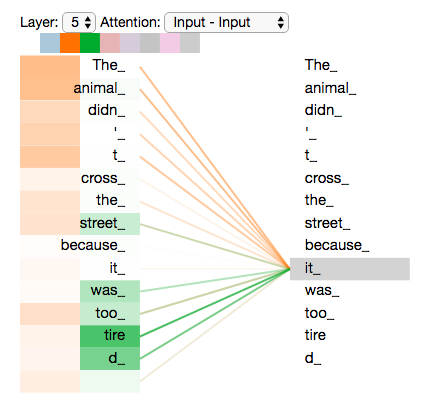

А вот с восемью

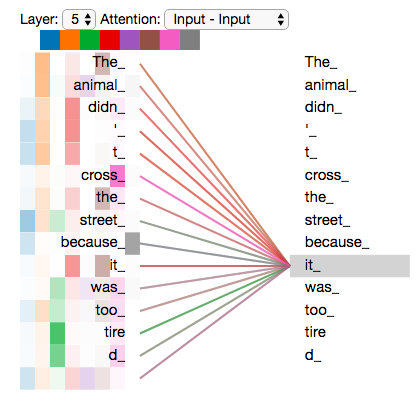

#### Позиционное кодирование

Мы пропустили одну важную вещь в нашей модели — способ учитывать порядок слов во входящем предложении.


Для решения этой проблемы в Трансформеры добавляют вектор в каждый входящий эмбеддинг. Эти векторы имеют определенный шаблон, который модель запоминает и который помогает определить позицию каждого слова или расстояние между разными словами в предложении. Интуиция здесь состоит в том, что добавление этих значений к эмбеддингам создает осмысленные расстояния между векторами эмбеддингов в процессе их проецирования в Q/K/V векторы и скалярного произведения при вычислении внимания.

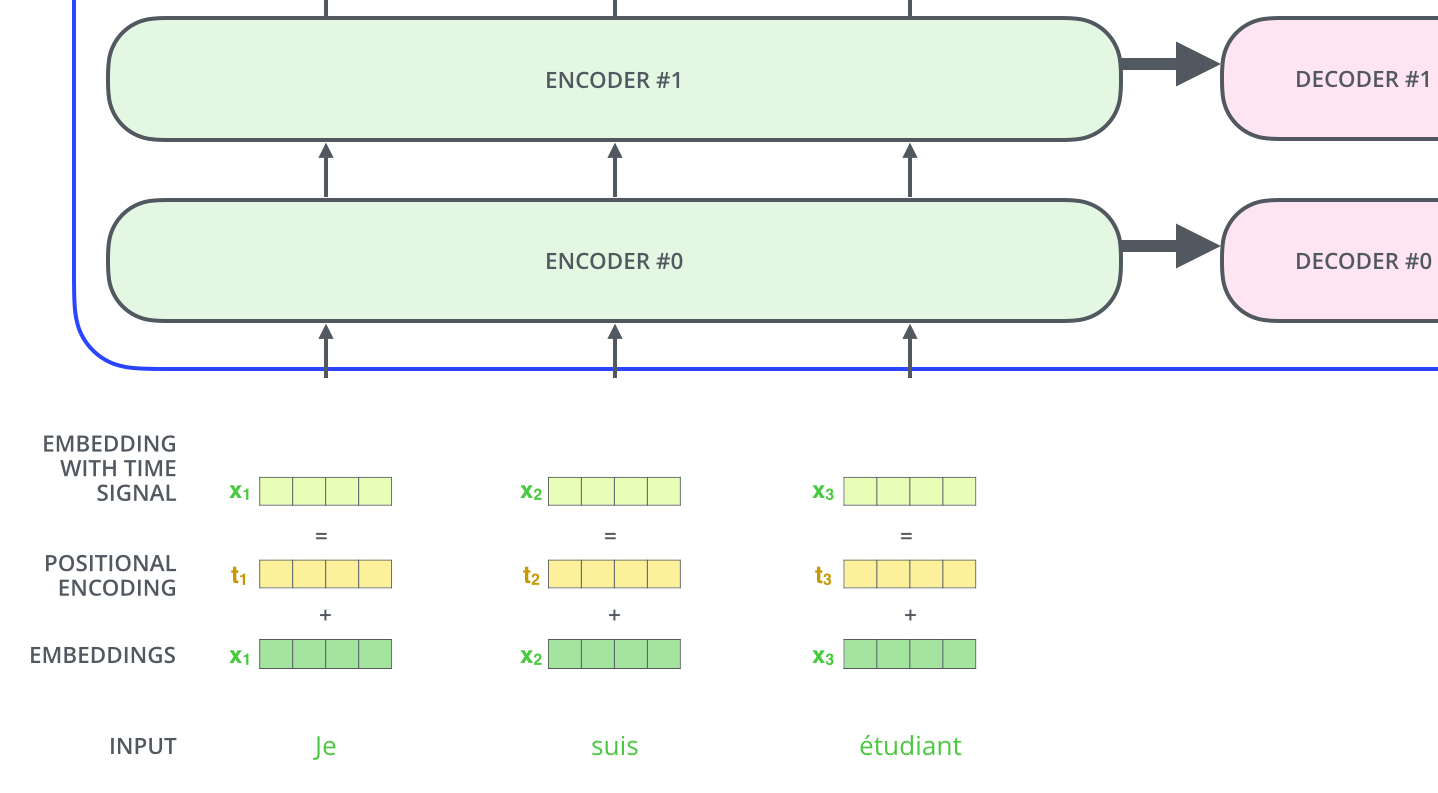

Вот пример

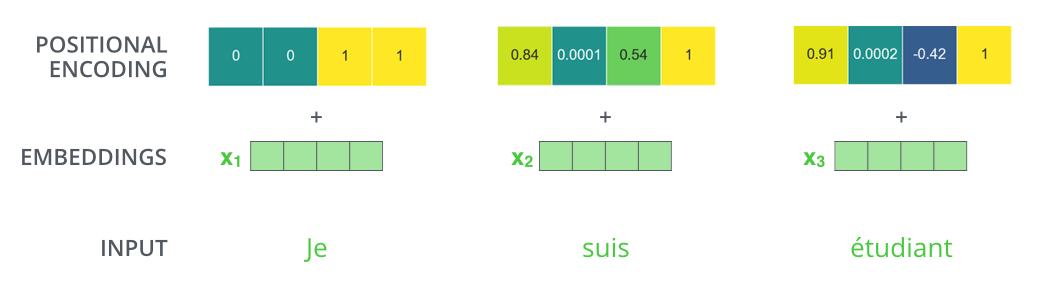

Вот как эти шиблоны могут выглядеть

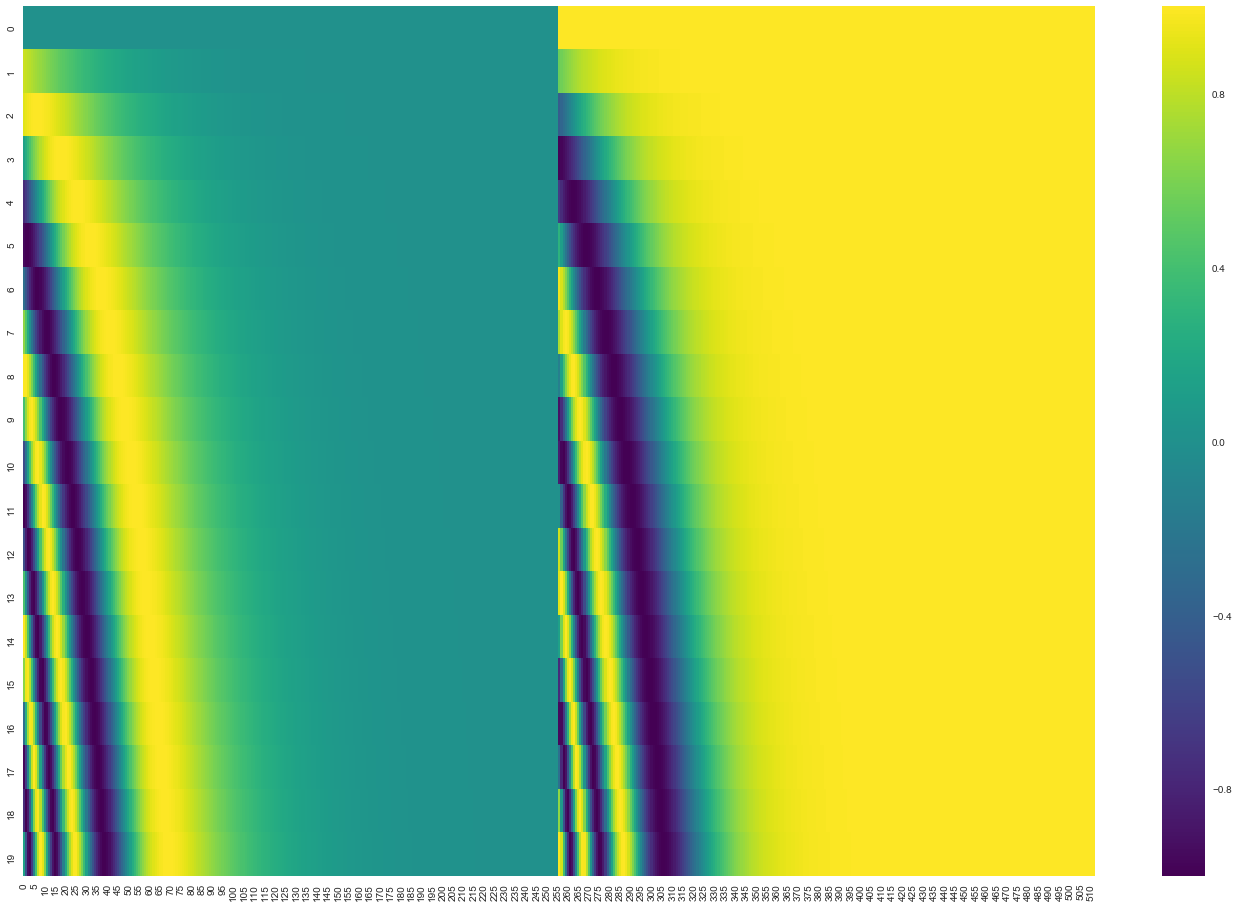

Реальный пример позиционного кодирования для 20 слов (строки) с эмбеддингами размером 512 (столбцы). Видно, что посередине есть разрыв: значения слева сгенерированы одной функцией (использующей синус), а справа – другой (использующей косинус). Они были конкатенированы для формирования каждого из векторов позиционного кодирования.

#### Забыли остаточную связь :)

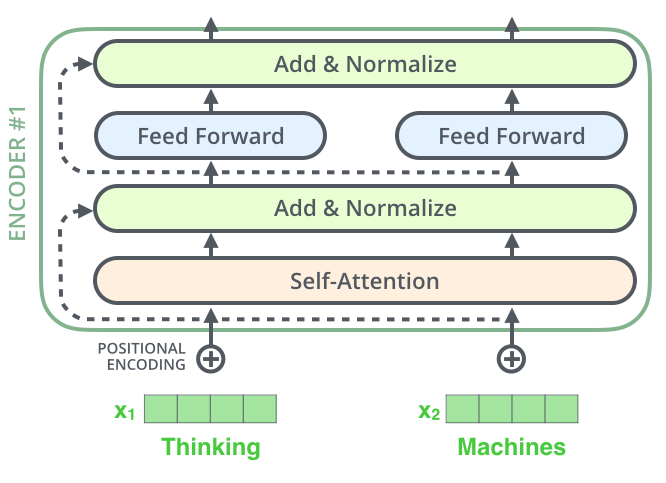

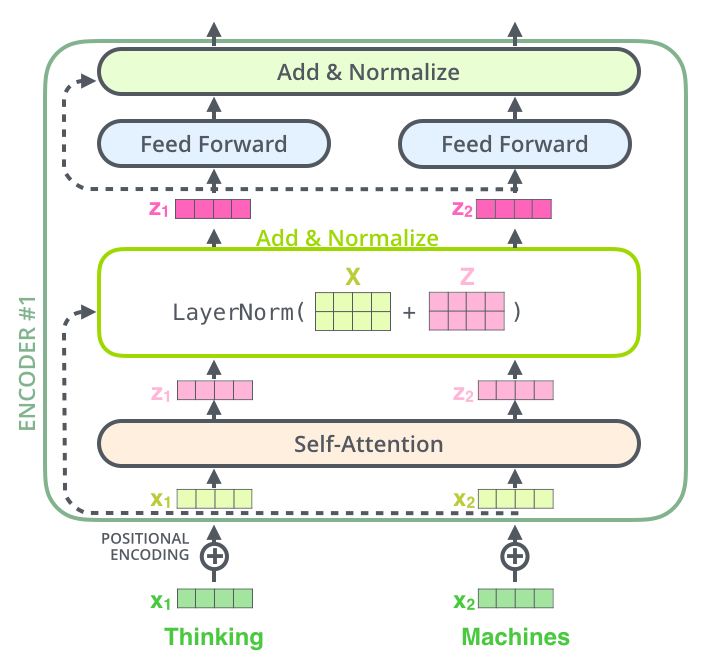

#### Итоговая архитектура выглядит вот так

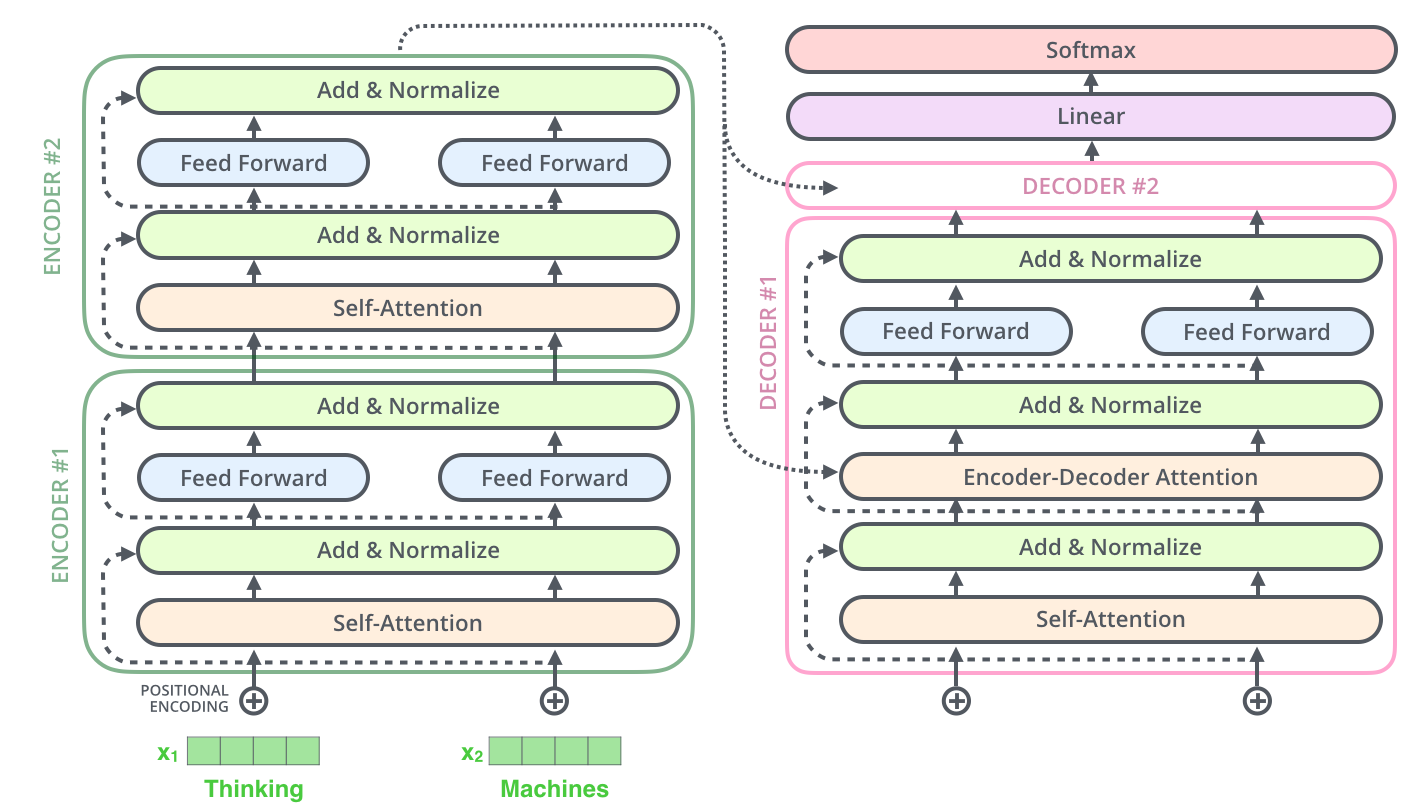Ё

https://www.pvsm.ru/images/2020/02/06/Transformer-v-kartinkah-29.gif

### Код модулей трансформера

In [1]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import math,copy,re
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import torchtextзшз
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")

In [2]:
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        Args:
            vocab_size: size of vocabulary
            embed_dim: dimension of embeddings
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            out: embedding vector
        """
        out = self.embed(x)
        return out

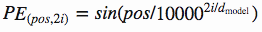


In [3]:
class PositionalEmbedding(nn.Module):
    def __init__(self,max_seq_len,embed_model_dim):
        """
        Args:
            seq_len: length of input sequence
            embed_model_dim: demension of embedding
        """
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_model_dim

        pe = torch.zeros(max_seq_len,self.embed_dim)
        for pos in range(max_seq_len):
            for i in range(0,self.embed_dim,2):
                pe[pos, i] = math.sin(pos / (10000 ** ((2 * i)/self.embed_dim)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/self.embed_dim)))
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)


    def forward(self, x):
        """
        Args:
            x: input vector
        Returns:
            x: output
        """
      
        # make embeddings relatively larger
        x = x * math.sqrt(self.embed_dim)
        #add constant to embedding
        seq_len = x.size(1)
        x = x + torch.autograd.Variable(self.pe[:,:seq_len], requires_grad=False)
        return x

In [4]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        Args:
            embed_dim: dimension of embeding vector output
            n_heads: number of self attention heads
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim    #512 dim
        self.n_heads = n_heads   #8
        self.single_head_dim = int(self.embed_dim / self.n_heads)   #512/8 = 64  . each key,query, value will be of 64d
       
        #key,query and value matrixes    #64 x 64   
        self.query_matrix = nn.Linear(self.single_head_dim , self.single_head_dim ,bias=False)  # single key matrix for all 8 keys #512x512
        self.key_matrix = nn.Linear(self.single_head_dim  , self.single_head_dim, bias=False)
        self.value_matrix = nn.Linear(self.single_head_dim ,self.single_head_dim , bias=False)
        self.out = nn.Linear(self.n_heads*self.single_head_dim ,self.embed_dim) 

    def forward(self,key,query,value,mask=None):    #batch_size x sequence_length x embedding_dim    # 32 x 10 x 512
        
        """
        Args:
           key : key vector
           query : query vector
           value : value vector
           mask: mask for decoder
        
        Returns:
           output vector from multihead attention
        """
        batch_size = key.size(0)
        seq_length = key.size(1)
        
        # query dimension can change in decoder during inference. 
        # so we cant take general seq_length
        seq_length_query = query.size(1)
        
        # 32x10x512
        key = key.view(batch_size, seq_length, self.n_heads, self.single_head_dim)  #batch_size x sequence_length x n_heads x single_head_dim = (32x10x8x64)
        query = query.view(batch_size, seq_length_query, self.n_heads, self.single_head_dim) #(32x10x8x64)
        value = value.view(batch_size, seq_length, self.n_heads, self.single_head_dim) #(32x10x8x64)
       
        k = self.key_matrix(key)       # (32x10x8x64)
        q = self.query_matrix(query)   
        v = self.value_matrix(value)

        q = q.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)    # (32 x 8 x 10 x 64)
        k = k.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
        v = v.transpose(1,2)  # (batch_size, n_heads, seq_len, single_head_dim)
       
        # computes attention
        # adjust key for matrix multiplication
        k_adjusted = k.transpose(-1,-2)  #(batch_size, n_heads, single_head_dim, seq_ken)  #(32 x 8 x 64 x 10)
        product = torch.matmul(q, k_adjusted)  #(32 x 8 x 10 x 64) x (32 x 8 x 64 x 10) = #(32x8x10x10)
      
        
        # fill those positions of product matrix as (-1e20) where mask positions are 0
        if mask is not None:
             product = product.masked_fill(mask == 0, float("-1e20"))

        #divising by square root of key dimension
        product = product / math.sqrt(self.single_head_dim) # / sqrt(64)

        #applying softmax
        scores = F.softmax(product, dim=-1)
 
        #mutiply with value matrix
        scores = torch.matmul(scores, v)  ##(32x8x 10x 10) x (32 x 8 x 10 x 64) = (32 x 8 x 10 x 64) 
        
        #concatenated output
        concat = scores.transpose(1,2).contiguous().view(batch_size, seq_length_query, self.single_head_dim*self.n_heads)  # (32x8x10x64) -> (32x10x8x64)  -> (32,10,512)
        
        output = self.out(concat) #(32,10,512) -> (32,10,512)
       
        return output

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(TransformerBlock, self).__init__()
        
        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads
        
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads)
        
        self.norm1 = nn.LayerNorm(embed_dim) 
        self.norm2 = nn.LayerNorm(embed_dim)
        
        self.feed_forward = nn.Sequential(
                          nn.Linear(embed_dim, expansion_factor*embed_dim),
                          nn.ReLU(),
                          nn.Linear(expansion_factor*embed_dim, embed_dim)
        )

        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)

    def forward(self,key,query,value):
        
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           norm2_out: output of transformer block
        
        """
        
        attention_out = self.attention(key,query,value)  #32x10x512
        attention_residual_out = attention_out + value  #32x10x512
        norm1_out = self.dropout1(self.norm1(attention_residual_out)) #32x10x512

        feed_fwd_out = self.feed_forward(norm1_out) #32x10x512 -> #32x10x2048 -> 32x10x512
        feed_fwd_residual_out = feed_fwd_out + norm1_out #32x10x512
        norm2_out = self.dropout2(self.norm2(feed_fwd_residual_out)) #32x10x512

        return norm2_out



class TransformerEncoder(nn.Module):
    """
    Args:
        seq_len : length of input sequence
        embed_dim: dimension of embedding
        num_layers: number of encoder layers
        expansion_factor: factor which determines number of linear layers in feed forward layer
        n_heads: number of heads in multihead attention
        
    Returns:
        out: output of the encoder
    """
    def __init__(self, seq_len, vocab_size, embed_dim, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerEncoder, self).__init__()
        
        self.embedding_layer = Embedding(vocab_size, embed_dim)
        self.positional_encoder = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList([TransformerBlock(embed_dim, expansion_factor, n_heads) for i in range(num_layers)])
    
    def forward(self, x):
        embed_out = self.embedding_layer(x)
        out = self.positional_encoder(embed_out)
        for layer in self.layers:
            out = layer(out,out,out)

        return out  #32x10x512

In [6]:
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8):
        super(DecoderBlock, self).__init__()

        """
        Args:
           embed_dim: dimension of the embedding
           expansion_factor: fator ehich determines output dimension of linear layer
           n_heads: number of attention heads
        
        """
        self.attention = MultiHeadAttention(embed_dim, n_heads=8)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(0.2)
        self.transformer_block = TransformerBlock(embed_dim, expansion_factor, n_heads)
        
    
    def forward(self, key, query, x,mask):
        
        """
        Args:
           key: key vector
           query: query vector
           value: value vector
           mask: mask to be given for multi head attention 
        Returns:
           out: output of transformer block
    
        """
        
        #we need to pass mask mask only to fst attention
        attention = self.attention(x,x,x,mask=mask) #32x10x512
        value = self.dropout(self.norm(attention + x))
        
        out = self.transformer_block(key, query, value)

        
        return out


class TransformerDecoder(nn.Module):
    def __init__(self, target_vocab_size, embed_dim, seq_len, num_layers=2, expansion_factor=4, n_heads=8):
        super(TransformerDecoder, self).__init__()
        """  
        Args:
           target_vocab_size: vocabulary size of taget
           embed_dim: dimension of embedding
           seq_len : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention
        
        """
        self.word_embedding = nn.Embedding(target_vocab_size, embed_dim)
        self.position_embedding = PositionalEmbedding(seq_len, embed_dim)

        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor=4, n_heads=8) 
                for _ in range(num_layers)
            ]

        )
        self.fc_out = nn.Linear(embed_dim, target_vocab_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x, enc_out, mask):
        
        """
        Args:
            x: input vector from target
            enc_out : output from encoder layer
            trg_mask: mask for decoder self attention
        Returns:
            out: output vector
        """
            
        
        x = self.word_embedding(x)  #32x10x512
        x = self.position_embedding(x) #32x10x512
        x = self.dropout(x)
     
        for layer in self.layers:
            x = layer(enc_out, x, enc_out, mask) 

        out = F.softmax(self.fc_out(x))

        return out

In [7]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, src_vocab_size, target_vocab_size, seq_length,num_layers=2, expansion_factor=4, n_heads=8):
        super(Transformer, self).__init__()
        
        """  
        Args:
           embed_dim:  dimension of embedding 
           src_vocab_size: vocabulary size of source
           target_vocab_size: vocabulary size of target
           seq_length : length of input sequence
           num_layers: number of encoder layers
           expansion_factor: factor which determines number of linear layers in feed forward layer
           n_heads: number of heads in multihead attention
        
        """
        
        self.target_vocab_size = target_vocab_size

        self.encoder = TransformerEncoder(seq_length, src_vocab_size, embed_dim, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        self.decoder = TransformerDecoder(target_vocab_size, embed_dim, seq_length, num_layers=num_layers, expansion_factor=expansion_factor, n_heads=n_heads)
        
    
    def make_trg_mask(self, trg):
        """
        Args:
            trg: target sequence
        Returns:
            trg_mask: target mask
        """
        batch_size, trg_len = trg.shape
        # returns the lower triangular part of matrix filled with ones
        trg_mask = torch.tril(torch.ones((trg_len, trg_len))).expand(
            batch_size, 1, trg_len, trg_len
        )
        return trg_mask    

    def decode(self,src,trg):
        """
        for inference
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out_labels : returns final prediction of sequence
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
        out_labels = []
        batch_size,seq_len = src.shape[0],src.shape[1]
        #outputs = torch.zeros(seq_len, batch_size, self.target_vocab_size)
        out = trg
        for i in range(seq_len): #10
            out = self.decoder(out,enc_out,trg_mask) #bs x seq_len x vocab_dim
            # taking the last token
            out = out[:,-1,:]
     
            out = out.argmax(-1)
            out_labels.append(out.item())
            out = torch.unsqueeze(out,axis=0)
          
        
        return out_labels
    
    def forward(self, src, trg):
        """
        Args:
            src: input to encoder 
            trg: input to decoder
        out:
            out: final vector which returns probabilities of each target word
        """
        trg_mask = self.make_trg_mask(trg)
        enc_out = self.encoder(src)
   
        outputs = self.decoder(trg, enc_out, trg_mask)
        return outputs

In [8]:
src_vocab_size = 11
target_vocab_size = 11
num_layers = 6
seq_length= 12


# let 0 be sos token and 1 be eos token
src = torch.tensor([[0, 2, 5, 6, 4, 3, 9, 5, 2, 9, 10, 1], 
                    [0, 2, 8, 7, 3, 4, 5, 6, 7, 2, 10, 1]])
target = torch.tensor([[0, 1, 7, 4, 3, 5, 9, 2, 8, 10, 9, 1], 
                       [0, 1, 5, 6, 2, 4, 7, 6, 2, 8, 10, 1]])

print(src.shape,target.shape)
model = Transformer(embed_dim=512, src_vocab_size=src_vocab_size, 
                    target_vocab_size=target_vocab_size, seq_length=seq_length,
                    num_layers=num_layers, expansion_factor=4, n_heads=8)

torch.Size([2, 12]) torch.Size([2, 12])


In [9]:
out = model(src, target)
out.shape

torch.Size([2, 12, 11])